In [1]:
# Importing the libraries 

import matplotlib.pyplot as plt
import numpy as np
from hilbert import decode, encode
from tqdm import tqdm
import seaborn as sns


from sklearn import metrics, svm, neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, balanced_accuracy_score, ConfusionMatrixDisplay,confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap
from imblearn.ensemble import BalancedRandomForestClassifier

import cv2
import os
from PIL import Image

Loading data from device.

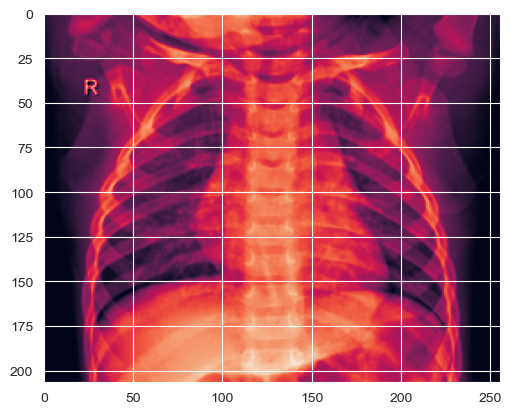

In [2]:
# set path
path = 'C:\\Users\\laura\\Desktop\\project\\chest_xray'

# Open the image using the specified file path
im = Image.open(path+'\\train\\NORMAL\\IM-0117-0001.jpeg')

# Display the thumbnail
im.thumbnail((256, 256))
plt.imshow(im)

In [3]:
p = 'C:\\Users\\laura\\Desktop\\Lauricek\\school\\mgr\\UGent\\Machine Learning\\project\\chest_xray\\train\\NORMAL\\IM-0117-0001.jpeg'
img_arr = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
resized_arr = cv2.resize(img_arr, (150, 150)) # Reshaping images to preferred size
new_arr = decode(resized_arr, 1, 5)
print(new_arr.shape)

(150, 150, 1)


In [4]:
img_size = 150
labels = ['PNEUMONIA', 'NORMAL']
def get_data(data_dir):
    data = [] 
    i = 0
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = 1 if label == 'PNEUMONIA' else 0
        for img in tqdm(os.listdir(path)):
            try:
                if not img.endswith('.DS_Store'): # Skip non-image files
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                    if resized_arr.shape == (img_size, img_size):
                        data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
                print(e)
    return np.array(data, dtype=object) # Specify dtype as object

In [9]:
#Load data 
train = get_data(path+'\\train')
test = get_data(path+'\\test')
val = get_data(path+'\\val')

100%|██████████| 8/8 [00:00<00:00, 92.56it/s]


Visualisation of one healthy and one pneumonia patient.

Text(0.5, 1.0, 'PNEUMONIA')

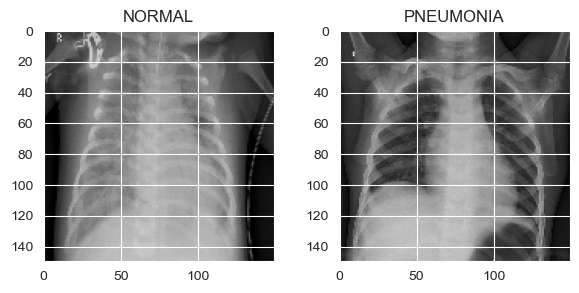

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(7,3))
axes[0].imshow(train[0][0], cmap='gray')
axes[0].set_title(labels[train[0][1]])
axes[1].imshow(train[-1][0], cmap='gray')
axes[1].set_title(labels[train[-1][1]])
#plt.savefig('pneum.png')

Hilbert curve data augmentation, to perceive the data structure in lower dimension.

In [10]:
# Hilbert curve data processing
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    h_curve = decode(feature, 1, 3)
    h_curve = h_curve.reshape(img_size*img_size)
    x_train.append(h_curve)
    y_train.append(label)

for feature, label in test:
    h_curve = decode(feature, 1, 3)
    h_curve = h_curve.reshape(img_size*img_size)
    x_test.append(h_curve)
    y_test.append(label)
    
for feature, label in val:
    h_curve = decode(feature, 1, 3)
    h_curve = h_curve.reshape(img_size*img_size)
    x_val.append(h_curve)
    y_val.append(label)

In [11]:
#data transformation to numpy array
x_train = np.vstack(x_train)
x_test = np.vstack(x_test)
x_val = np.vstack(x_val)

x_train  = np.vstack([x_train, x_val])

y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

y_train = np.concatenate([y_train, y_val])


(5232, 22500)
(5232,)
(624, 22500)


Data visualization with UMAP and PCA

In [12]:
# Data scaling 
scaled_bags_train = StandardScaler().fit_transform(x_train)
pca_bags_train = PCA(n_components=2).fit_transform(scaled_bags_train)

In [13]:
X_umap_train = umap.UMAP().fit_transform(scaled_bags_train)

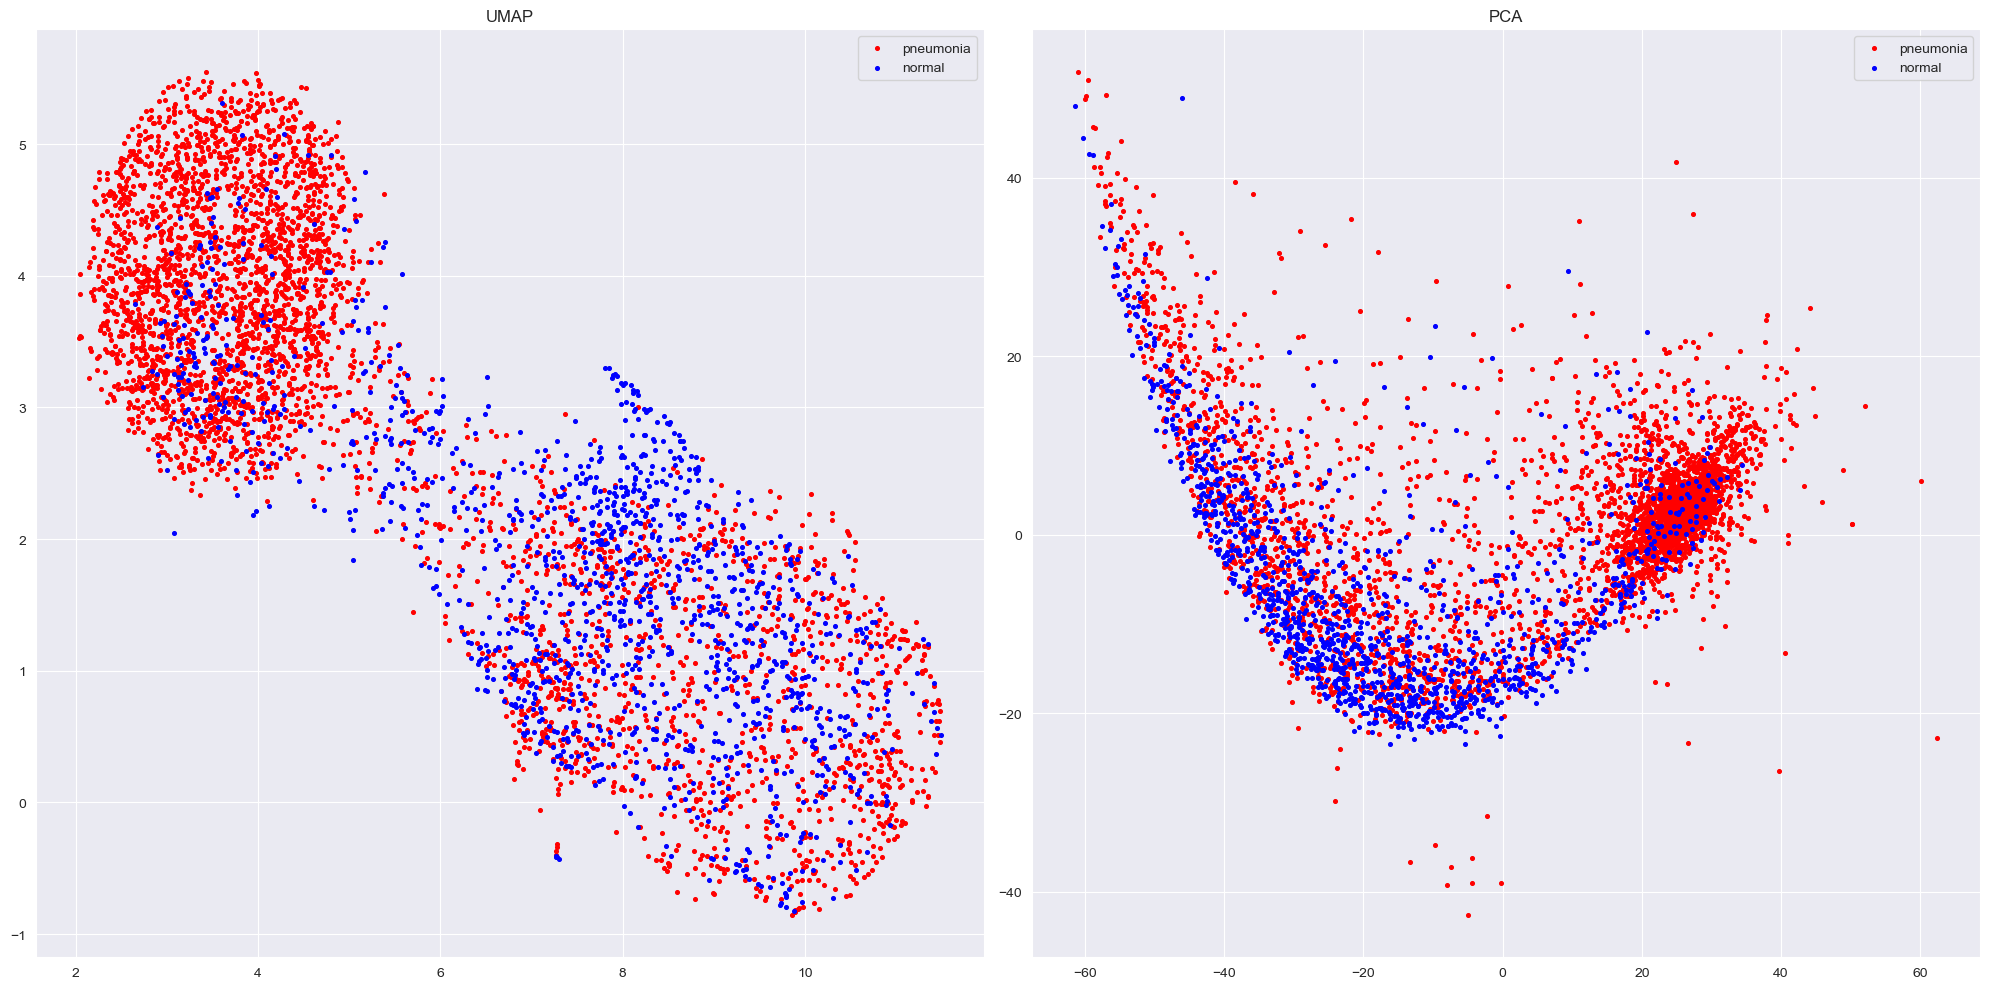

In [15]:
# Set a common color palette for both UMAP and PCA plots
#color_palette = {'pneumonia': 'red', 'normal': 'blue'}
indices0 = [index for index, value in enumerate(y_train) if value == 0]
indices1 = [index for index, value in enumerate(y_train) if value == 1]


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# UMAP plot
ax[0].scatter(X_umap_train[indices1, 0].flatten(), X_umap_train[indices1, 1].flatten(), s=7, c='red', label='pneumonia')
ax[0].scatter(X_umap_train[indices0, 0].flatten(), X_umap_train[indices0, 1].flatten(), s=7, c='blue', label='normal')
ax[0].legend()
ax[0].set_title('UMAP')

# PCA plot
ax[1].scatter(pca_bags_train[indices1, 0], pca_bags_train[indices1, 1], s=7, c='red', label='pneumonia')
ax[1].scatter(pca_bags_train[indices0, 0], pca_bags_train[indices0, 1], s=7, c='blue', label='normal')
ax[1].legend()
ax[1].set_title('PCA')


plt.tight_layout()
#plt.savefig('data2D.png')
plt.show()


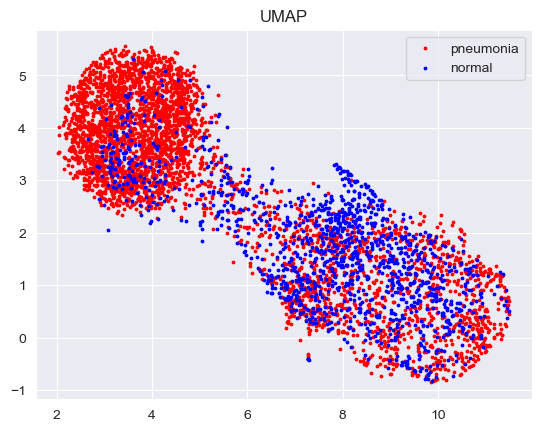

In [18]:
# UMAP plot
plt.scatter(X_umap_train[indices1, 0].flatten(), X_umap_train[indices1, 1].flatten(), s=3, c='red', label='pneumonia')
plt.scatter(X_umap_train[indices0, 0].flatten(), X_umap_train[indices0, 1].flatten(), s=3, c='blue', label='normal')
plt.legend()
plt.title('UMAP')
plt.savefig('data2D.png')
plt.show()

Visualisation of the class imbalance in the data

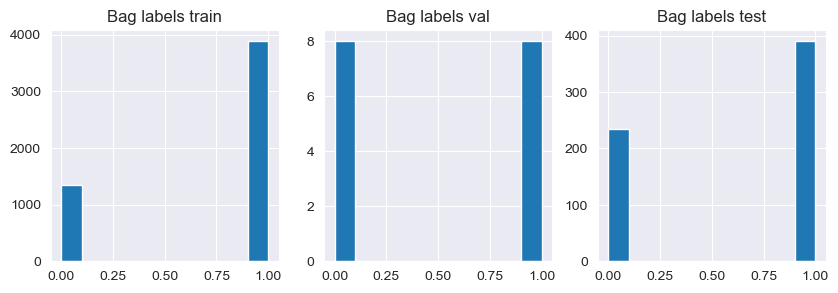

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
axes[0].hist(y_train)
axes[0].set_title('Bag labels train')
axes[1].hist(y_val)
axes[1].set_title('Bag labels val')
axes[2].hist(y_test)
axes[2].set_title('Bag labels test')
#plt.savefig('label_dist.png')
plt.show()

Defining precision metrics

In [19]:
# Precision metrics
def get_roc_auc(y_pred, y_true):
    fpr, tpr, _  = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def get_pr_auc(y_pred, y_true):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def class_accs(y_pred, y_true):
    """
    Calculates per-class accuracy of a classification
    """ 
    acc0 = ((y_pred == y_true) & (y_true == 0)).astype(int).sum() / (y_true == 0).sum()
    acc1 = ((y_pred == y_true) & (y_true == 1)).astype(int).sum() / (y_true == 1).sum()
    return acc0, acc1


def print_metrics(y_pred, y_true):
    """
    Reports summary of performance metrics
    """
    f1 = metrics.f1_score(y_true, y_pred)
    acc = metrics.accuracy_score(y_true, y_pred)
    re = metrics.recall_score(y_true, y_pred)
    pr = metrics.precision_score(y_true, y_pred)
    acc0, acc1 = class_accs(y_pred, y_true)
    bal_acc = balanced_accuracy_score(y_true,y_pred)
    roc_auc = get_roc_auc(y_pred,y_true)
    pr_auc = get_pr_auc(y_pred, y_true)
    print(f'\tRecall = {re:.3f}')
    print(f'\tPrecision = {pr:.3f}')
    print(f'\tF1 = {f1:.3f}')
    print(f'\tBalanced accuracy: {bal_acc:.3f}')
    print(f'\tAccuracy = {acc:.3f}')
    print(f'\t\tclass 0: {acc0:.3f}')
    print(f'\t\tclass 1: {acc1:.3f}')
    print(f'\tArea under the ROC curve: {roc_auc:.3f}')
    print(f'\tArea under the PR curve: {pr_auc:.3f}')
    # Display confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix')
    plt.show()


Training different SVM configurations

In [35]:
svm0 = SVC(kernel='linear', C=1.0)
svm0.fit(x_train, y_train)
y_pred_SVM0 = svm0.predict(x_test)


	Recall = 0.946
	Precision = 0.695
	F1 = 0.801
	Balanced accuracy: 0.627
	Accuracy = 0.707
		class 0: 0.308
		class 1: 0.946
	Area under the ROC curve: 0.627
	Area under the PR curve: 0.837


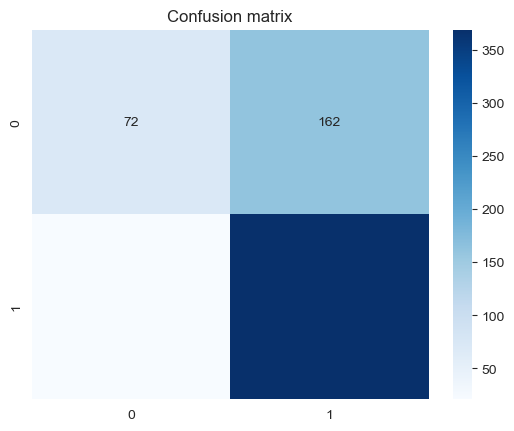

In [36]:
print_metrics(y_pred_SVM0,y_test)

In [29]:
svm1 = SVC(kernel='linear', C=1.0, class_weight={1: 1, 0: 10})
svm1.fit(x_train, y_train)
y_pred_SVM1 = svm1.predict(x_test)

	Recall = 0.946
	Precision = 0.695
	F1 = 0.801
	Balanced accuracy: 0.627
	Accuracy = 0.707
		class 0: 0.308
		class 1: 0.946
	Area under the ROC curve: 0.627
	Area under the PR curve: 0.837


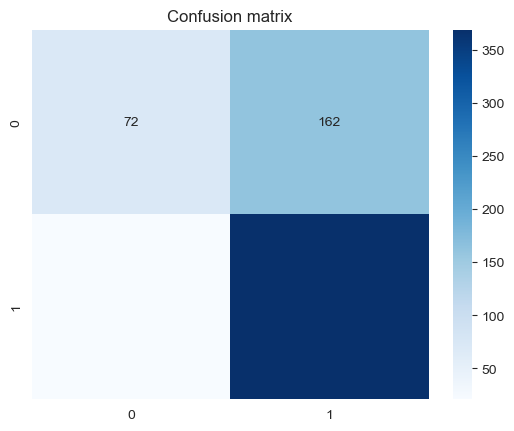

In [30]:
print_metrics(y_pred_SVM1,y_test)

In [39]:
svm2 = SVC(kernel='rbf', C=1.0, class_weight={1: 1.0, 0: 10})
svm2.fit(x_train, y_train)
y_pred_SVM2 = svm2.predict(x_test)

	Recall = 0.964
	Precision = 0.695
	F1 = 0.808
	Balanced accuracy: 0.629
	Accuracy = 0.713
		class 0: 0.295
		class 1: 0.964
	Area under the ROC curve: 0.629
	Area under the PR curve: 0.841


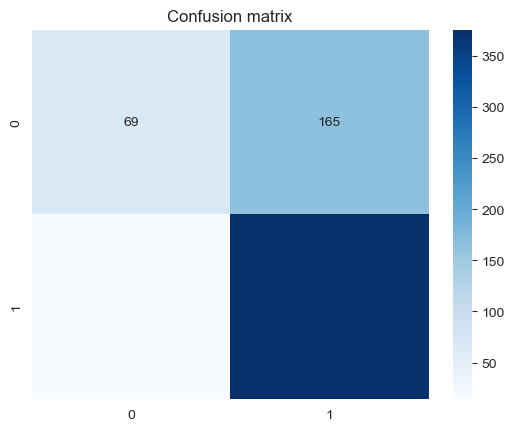

In [40]:
print_metrics(y_pred_SVM2,y_test)

In [20]:
svm3 = SVC(kernel='poly', degree=2, C=1.0, class_weight={1: 1.0, 0: 20})
svm3.fit(x_train, y_train)
y_pred_SVM3 = svm3.predict(x_test)

	Recall = 0.956
	Precision = 0.692
	F1 = 0.803
	Balanced accuracy: 0.624
	Accuracy = 0.707
		class 0: 0.291
		class 1: 0.956
	Area under the ROC curve: 0.624
	Area under the PR curve: 0.838


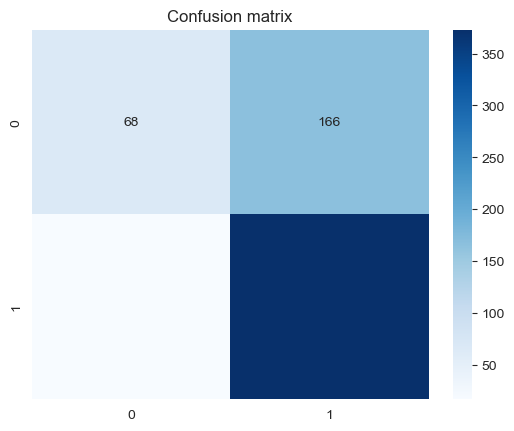

In [21]:
print_metrics(y_pred_SVM3,y_test)

Handling class imbalance through different resampling techniques.

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

In [15]:
# Oversampling
Xo, yo = SMOTE(sampling_strategy='auto').fit_resample(x_train,y_train) # 'auto' ~ get equal representation of classes

svm_over = SVC(kernel='linear', C=1.0)
svm_over.fit(Xo, yo)
y_pred_SVMover = svm_over.predict(x_test)

(array([3883.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3883.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

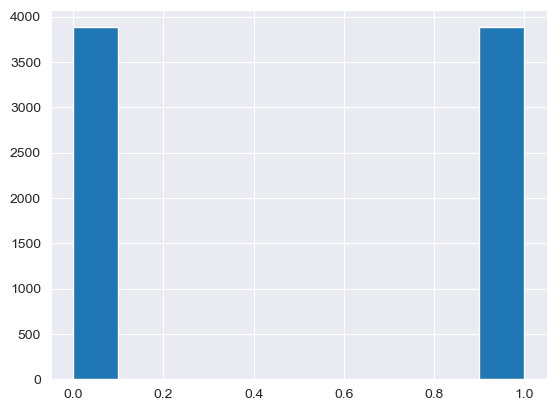

In [16]:
plt.hist(yo)

	Recall = 0.946
	Precision = 0.695
	F1 = 0.801
	Balanced accuracy: 0.627
	Accuracy = 0.707
		class 0: 0.308
		class 1: 0.946
	Area under the ROC curve: 0.627
	Area under the PR curve: 0.837


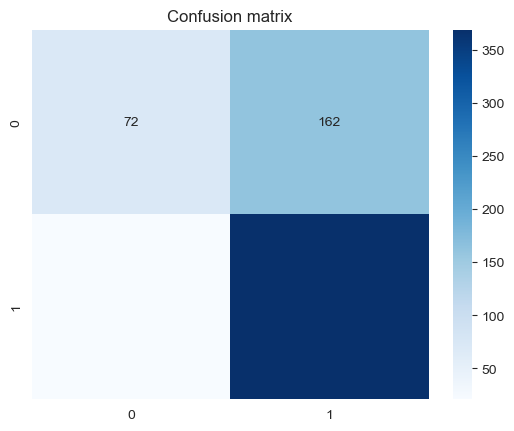

In [18]:
print_metrics(y_pred_SVMover, y_test)

(array([1553.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2218.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

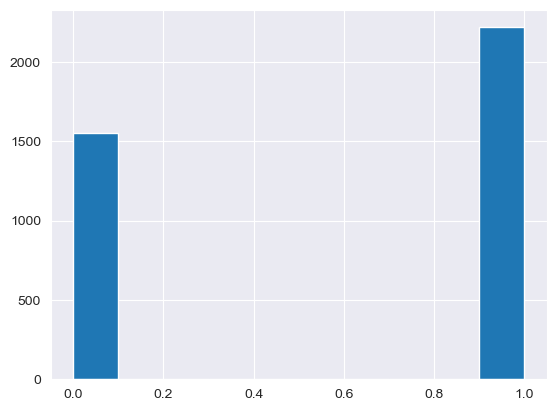

In [26]:
# Oversampling + undersampling
over = SMOTE(sampling_strategy=0.4) # desired ratio (n_minority/n_majority)
under = RandomUnderSampler(sampling_strategy=0.7)
pipeline = Pipeline(steps=[('oversample', over), ('undersample', under)])
Xou, you = pipeline.fit_resample(x_train, y_train)

plt.hist(you)

In [27]:
svm_ou = SVC(kernel='linear', C=1.0)
svm_ou.fit(Xou, you)
y_pred_SVMou = svm_ou.predict(x_test)

	Recall = 0.879
	Precision = 0.722
	F1 = 0.793
	Balanced accuracy: 0.658
	Accuracy = 0.713
		class 0: 0.436
		class 1: 0.879
	Area under the ROC curve: 0.658
	Area under the PR curve: 0.838


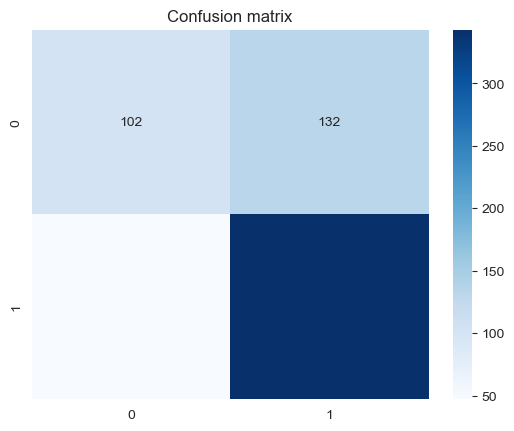

In [28]:
print_metrics(y_pred_SVMou, y_test)